<a href="https://colab.research.google.com/github/Jjmorenog/SimulacionUllanos2023/blob/main/Lab4JuanMoreno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Funciones

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.graphics import tsaplots
import tqdm
import inspect
import warnings
warnings.filterwarnings('ignore')

def calcular_correlaciones(df):
    # a. Correlaciones de retraso estimadas
    #Correlaciones de retraso estimadas (Estimated lag correlations)
    fig = tsaplots.plot_acf(df, lags=40, zero=False)

    plt.title("Autocorrelation")
    plt.xlabel("Lag at k")
    plt.ylabel("Correlation")
    plt.yticks([-0.5,0,0.5])
    plt.show();

def generar_diagrama_dispersión(df):
    # b. Diagrama de dispersión
    plt.scatter(range(len(df)), df.iloc[:, 0])
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title('Diagrama de dispersión')
    plt.show()

def generar_histograma(df):
    # c. Histograma de cantidad de eventos (llegadas)
    plt.hist(df.iloc[:, 0], bins=20)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.title('Histograma de cantidad de eventos')
    plt.show()

def calcular_estadisticos(df):
    # Estadísticos
    # a. Media
    media = df.mean().iloc[0]
    print("\nMedia:")
    print(media)

    # b. Desviación Estándar
    desviacion_estandar = df.std().iloc[0]
    print("\nDesviación Estándar:")
    print(desviacion_estandar)

    # c. Mediana
    mediana = df.median().iloc[0]
    print("\nMediana:")
    print(mediana)

    # d. Mínimo
    minimo = df.min().iloc[0]
    print("\nMínimo:")
    print(minimo)

    # e. Máximo
    maximo = df.max().iloc[0]
    print("\nMáximo:")
    print(maximo)

def seleccionar_distribuciones(familia='realall', verbose=True):
    '''
    Esta función selecciona un subconjunto de las distribuciones disponibles
    en scipy.stats

    Parameters
    ----------
    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas

    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).

    Returns
    -------
    distribuciones: list
        listado con las distribuciones (los objetos) seleccionados.

    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.

    Notes
    -----
        Las distribuciones levy_stable y vonmises han sido excluidas por el momento.

    '''

    distribuciones = [getattr(stats,d) for d in dir(stats) \
                     if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]

    exclusiones = ['levy_stable', 'vonmises']
    distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]

    dominios = {
        'realall' : [-np.inf, np.inf],
        'realline': [np.inf,np.inf],
        'realplus': [0, np.inf],
        'real0to1': [0, 1],
        'discreta': [None, None],
    }

    distribucion = []
    tipo = []
    dominio_inf = []
    dominio_sup = []

    for dist in distribuciones:
        distribucion.append(dist.name)
        tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
        dominio_inf.append(dist.a)
        dominio_sup.append(dist.b)

    info_distribuciones = pd.DataFrame({
                            'distribucion': distribucion,
                            'tipo': tipo,
                            'dominio_inf': dominio_inf,
                            'dominio_sup': dominio_sup
                          })

    info_distribuciones = info_distribuciones \
                          .sort_values(by=['dominio_inf', 'dominio_sup'])\
                          .reset_index(drop=True)

    if familia in ['realall', 'realline', 'realplus', 'real0to1']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
        condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                    (info_distribuciones['dominio_sup'] == dominios[familia][1])
        info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)

    if familia in ['discreta']:
        info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']

    seleccion = [dist for dist in distribuciones \
                 if dist.name in info_distribuciones['distribucion'].values]


    if verbose:
        print("---------------------------------------------------")
        print("       Distribuciones seleccionadas                ")
        print("---------------------------------------------------")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(info_distribuciones)

    return seleccion


def comparar_distribuciones(x, familia='realall', ordenar='aic', verbose=True):
    '''
    Esta función selecciona y ajusta un subconjunto de las distribuciones
    disponibles en scipy.stats. Para cada distribución calcula los valores de
    Log Likelihood, AIC y BIC.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
        realall: distribuciones de la familia `realline` + `realplus`
        realline: distribuciones continuas en el dominio (-inf, +inf)
        realplus: distribuciones continuas en el dominio [0, +inf)
        real0to1: distribuciones continuas en el dominio [0,1]
        discreta: distribuciones discretas

    ordenar : {'aic', 'bic'}
        criterio de ordenación de mejor a peor ajuste.

    verbose : bool
        Si se muestra información de las distribuciones seleccionadas
        (the default `True`).

    Returns
    -------
    resultados: data.frame
        distribucion: nombre de la distribución.
        log_likelihood: logaritmo del likelihood del ajuste.
        aic: métrica AIC.
        bic: métrica BIC.
        n_parametros: número de parámetros de la distribución de la distribución.
        parametros: parámetros del tras el ajuste

    Raises
    ------
    Exception
        Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
        o 'discreta'.

    Notes
    -----

    '''

    distribuciones = seleccionar_distribuciones(familia=familia, verbose=verbose)
    distribucion_ = []
    log_likelihood_= []
    aic_ = []
    bic_ = []
    n_parametros_ = []
    parametros_ = []

    for i, distribucion in enumerate(distribuciones):

        print(f"{i+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")

        try:
            parametros = distribucion.fit(data=x)
            nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                 if not p=='x'] + ["loc","scale"]
            parametros_dict = dict(zip(nombre_parametros, parametros))
            log_likelihood = distribucion.logpdf(x, *parametros).sum()
            aic = -2 * log_likelihood + 2 * len(parametros)
            bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

            distribucion_.append(distribucion.name)
            log_likelihood_.append(log_likelihood)
            aic_.append(aic)
            bic_.append(bic)
            n_parametros_.append(len(parametros))
            parametros_.append(parametros_dict)

            resultados = pd.DataFrame({
                            'distribucion': distribucion_,
                            'log_likelihood': log_likelihood_,
                            'aic': aic_,
                            'bic': bic_,
                            'n_parametros': n_parametros_,
                            'parametros': parametros_,

                         })

            resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

        except Exception as e:
            print(f"Error al tratar de ajustar la distribución {distribucion.name}")
            print(e)
            print("")

    return resultados
def plot_distribucion(x, nombre_distribucion, ax=None):
    '''
    Esta función superpone la curva de densidad de una distribución con el
    histograma de los datos.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    nombre_distribuciones : str
        nombre de una de las distribuciones disponibles en `scipy.stats`.

    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado

    Raises
    ------

    Notes
    -----
    '''

    distribucion = getattr(stats, nombre_distribucion)

    parametros = distribucion.fit(data=x)

    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                         if not p=='x'] + ["loc","scale"]
    parametros_dict = dict(zip(nombre_parametros, parametros))

    log_likelihood = distribucion.logpdf(x, *parametros).sum()

    aic = -2 * log_likelihood + 2 * len(parametros)
    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

    x_hat = np.linspace(min(x), max(x), num=100)
    y_hat = distribucion.pdf(x_hat, *parametros)

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))

    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5);
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribución')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    print('---------------------')
    print('Resultados del ajuste')
    print('---------------------')
    print(f"Distribución:   {distribucion.name}")
    print(f"Dominio:        {[distribucion.a, distribucion.b]}")
    print(f"Parámetros:     {parametros_dict}")
    print(f"Log likelihood: {log_likelihood}")
    print(f"AIC:            {aic}")
    print(f"BIC:            {bic}")

    return ax


def plot_multiple_distribuciones(x, nombre_distribuciones, ax=None):
    '''
    Esta función superpone las curvas de densidad de varias distribuciones
    con el histograma de los datos.

    Parameters
    ----------
    x : array_like
        datos con los que ajustar la distribución.

    nombre_distribuciones : list
        lista con nombres de distribuciones disponibles en `scipy.stats`.

    Returns
    -------
    resultados: matplotlib.ax
        gráfico creado

    Raises
    ------

    Notes
    -----
    '''

    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))

    ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Ajuste distribuciones')
    ax.set_xlabel('x')
    ax.set_ylabel('Densidad de probabilidad')

    for nombre in nombre_distribuciones:

        distribucion = getattr(stats, nombre)

        parametros = distribucion.fit(data=x)

        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                             if not p=='x'] + ["loc","scale"]
        parametros_dict = dict(zip(nombre_parametros, parametros))

        log_likelihood = distribucion.logpdf(x, *parametros).sum()

        aic = -2 * log_likelihood + 2 * len(parametros)
        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

        x_hat = np.linspace(min(x), max(x), num=100)
        y_hat = distribucion.pdf(x_hat, *parametros)
        ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)

    ax.legend();

    return ax

Carga de datos


In [ ]:
# Leer datos desde el archivo .txt
archivo1 = '/content/VelocidadDescarga.csv'
datos1 = pd.read_csv(archivo1, sep='\t')
archivo2 = '/content/VelocidadCarga.csv'
datos2 = pd.read_csv(archivo2, sep='\t')
archivo3 = '/content/Latencia.csv'
datos3 = pd.read_csv(archivo3, sep='\t')
archivo4 = '/content/Jitter.csv'
datos4 = pd.read_csv(archivo4, sep='\t')


Ajuste de distribuiciones

In [ ]:
resultados1 = comparar_distribuciones(
                x=datos1.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados2 = comparar_distribuciones(
                x=datos2.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados3 = comparar_distribuciones(
                x=datos3.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )
resultados4 = comparar_distribuciones(
                x=datos4.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False
            )

1/32 Ajustando distribución: cauchy
2/32 Ajustando distribución: crystalball
3/32 Ajustando distribución: dgamma
4/32 Ajustando distribución: dweibull
5/32 Ajustando distribución: exponnorm
6/32 Ajustando distribución: genextreme
7/32 Ajustando distribución: genhyperbolic
8/32 Ajustando distribución: genlogistic
9/32 Ajustando distribución: gennorm
10/32 Ajustando distribución: gumbel_l
11/32 Ajustando distribución: gumbel_r
12/32 Ajustando distribución: hypsecant
13/32 Ajustando distribución: johnsonsu
14/32 Ajustando distribución: kappa4
15/32 Ajustando distribución: laplace
16/32 Ajustando distribución: laplace_asymmetric
17/32 Ajustando distribución: loggamma
18/32 Ajustando distribución: logistic
19/32 Ajustando distribución: loguniform
20/32 Ajustando distribución: moyal
21/32 Ajustando distribución: nct
22/32 Ajustando distribución: norm
23/32 Ajustando distribución: norminvgauss
24/32 Ajustando distribución: pearson3
25/32 Ajustando distribución: powernorm
26/32 Ajustando distr

Dataset A

Dataset A

Media:
149.7969696969697

Desviación Estándar:
57.60941755237213

Mediana:
161.1

Mínimo:
43.5

Máximo:
257.0


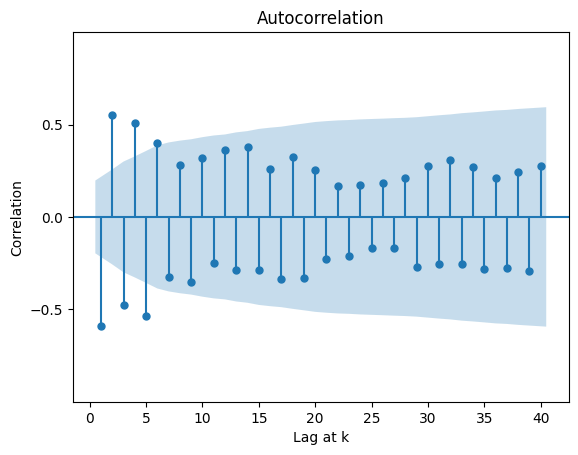

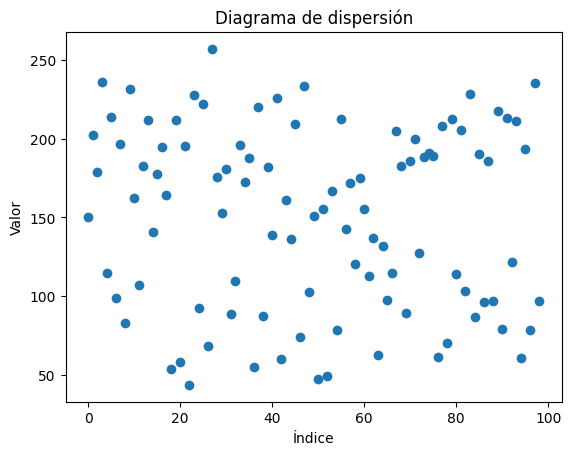

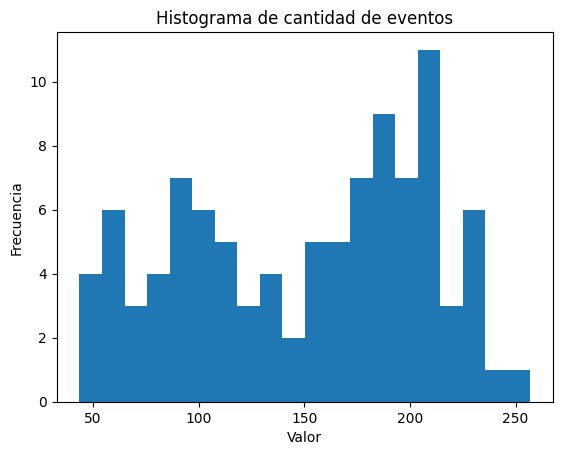

---------------------
Resultados del ajuste
---------------------
Distribución:   gennorm
Dominio:        [-inf, inf]
Parámetros:     {'beta': 9.053182733894456, 'loc': 145.07659627203282, 'scale': 99.20615243137952}
Log likelihood: -529.3113162775378
AIC:            1064.6226325550756
BIC:            1072.4079921054795


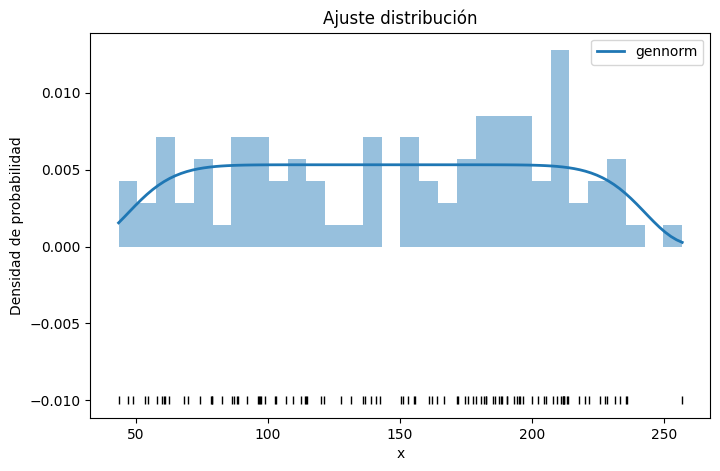

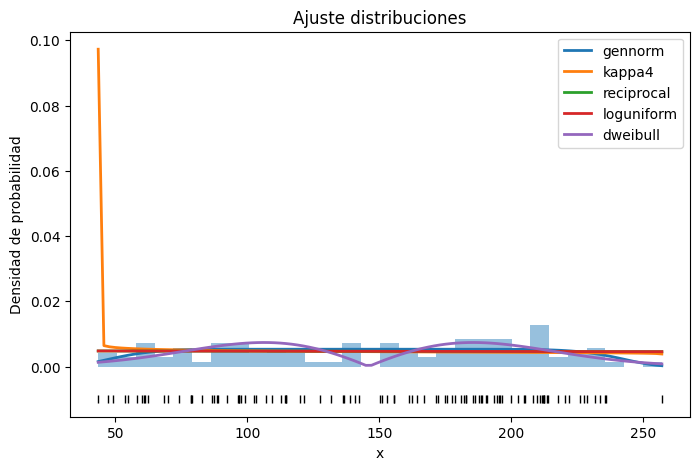

In [ ]:
print("Dataset A")
calcular_estadisticos(datos1)
calcular_correlaciones(datos1)
generar_diagrama_dispersión(datos1)
generar_histograma(datos1)


fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos1.to_numpy(),
    nombre_distribucion=resultados1['distribucion'][0],
    ax=ax
);
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos1.to_numpy(),
    nombre_distribuciones=resultados1['distribucion'][:5],
    ax=ax
);



Dataset B

Dataset B


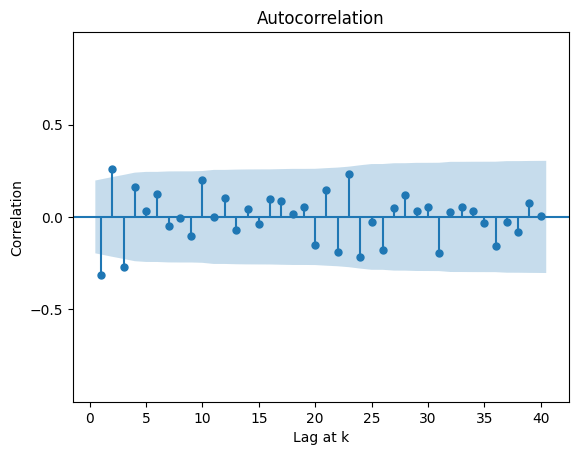

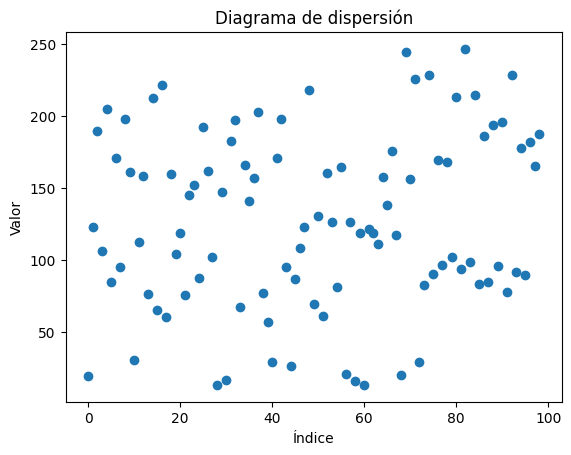

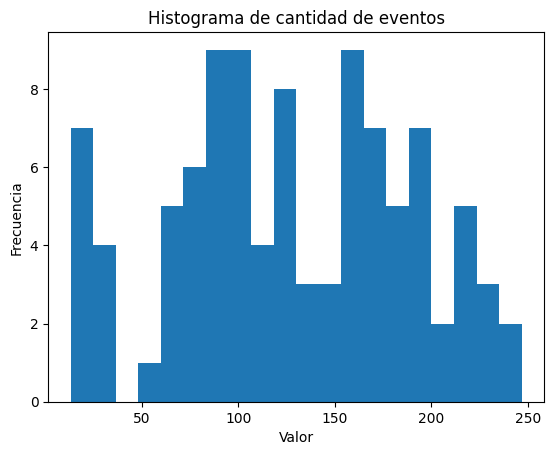


Media:
127.53232323232324

Desviación Estándar:
61.1249737336162

Mediana:
122.8

Mínimo:
13.3

Máximo:
246.7
---------------------
Resultados del ajuste
---------------------
Distribución:   kappa4
Dominio:        [-inf, inf]
Parámetros:     {'h': 1.1073372730088025, 'k': 0.9572563596229581, 'loc': -10.656806687971125, 'scale': 246.6196528063058}
Log likelihood: -536.8790722548473
AIC:            1081.7581445096946
BIC:            1092.138623910233


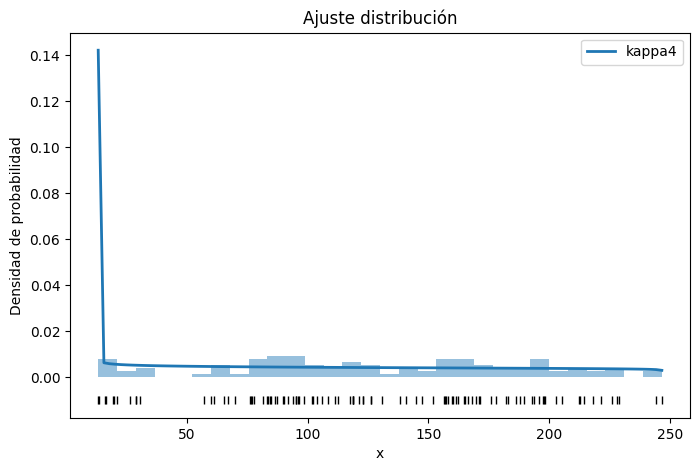

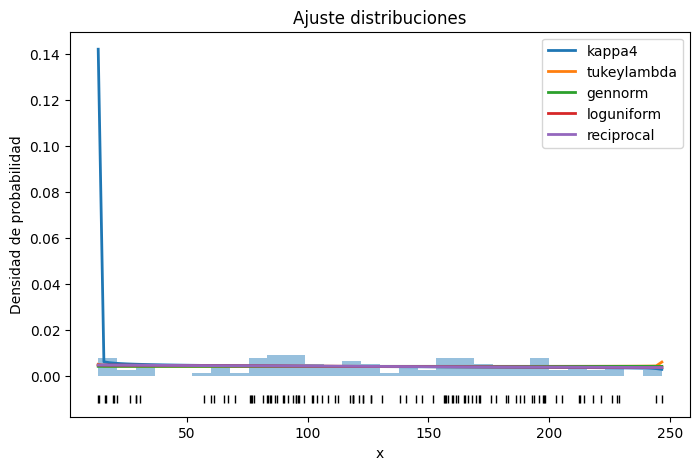

In [ ]:
print("Dataset B")
calcular_correlaciones(datos2)
generar_diagrama_dispersión(datos2)
generar_histograma(datos2)
calcular_estadisticos(datos2)

fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos2.to_numpy(),
    nombre_distribucion=resultados2['distribucion'][0],
    ax=ax
);
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos2.to_numpy(),
    nombre_distribuciones=resultados2['distribucion'][:5],
    ax=ax
);


Dataset C

Dataset C


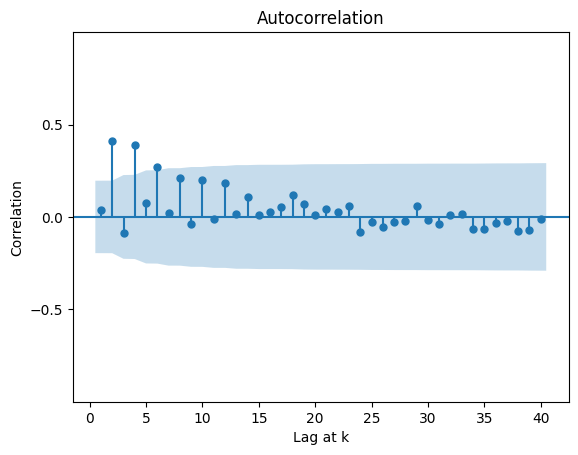

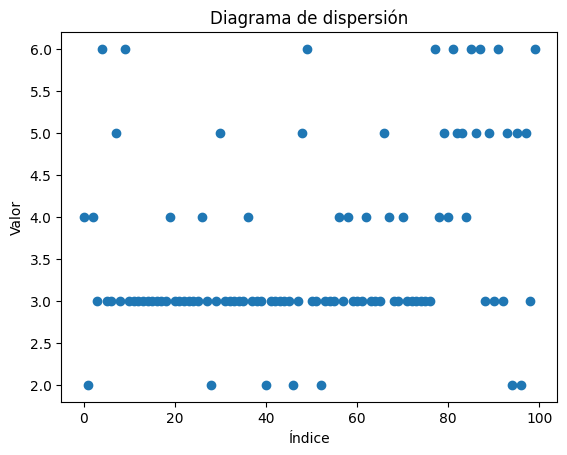

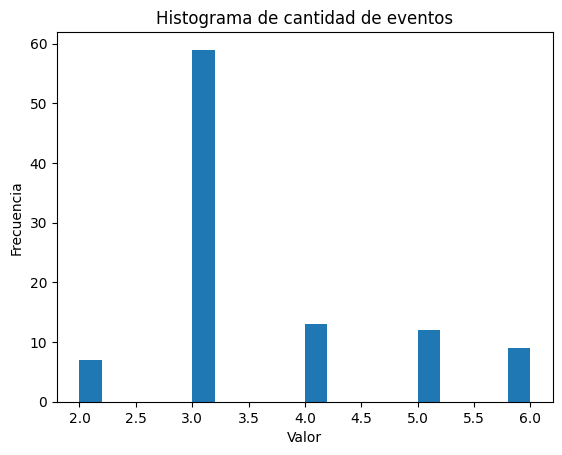


Media:
3.57

Desviación Estándar:
1.0848357879737776

Mediana:
3.0

Mínimo:
2

Máximo:
6
---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -0.5269354493616205, 'b': 0.13382683883928445, 'loc': 3.0, 'scale': 1.987970904475215e-17}
Log likelihood: 1444.0269662670826
AIC:            -2880.053932534165
BIC:            -2869.633251790213


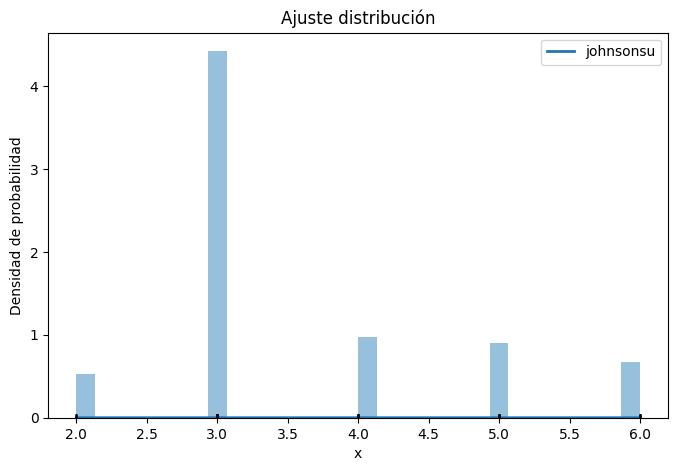

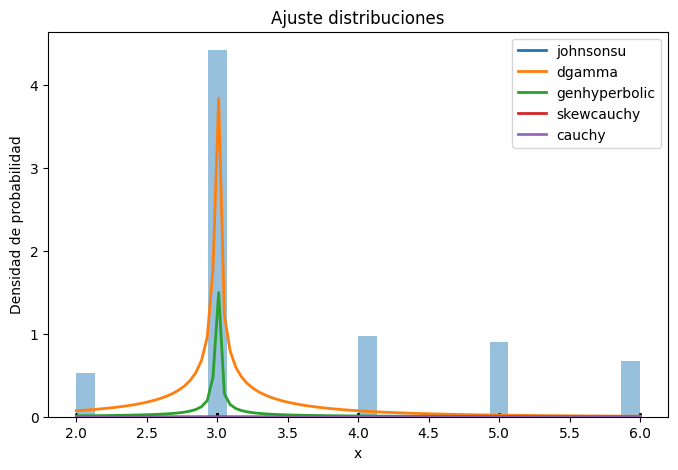

In [ ]:
print("Dataset C")
calcular_correlaciones(datos3)
generar_diagrama_dispersión(datos3)
generar_histograma(datos3)
calcular_estadisticos(datos3)
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos3.to_numpy(),
    nombre_distribucion=resultados3['distribucion'][0],
    ax=ax
);
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos3.to_numpy(),
    nombre_distribuciones=resultados3['distribucion'][:5],
    ax=ax
);


Dataset D

Dataset D


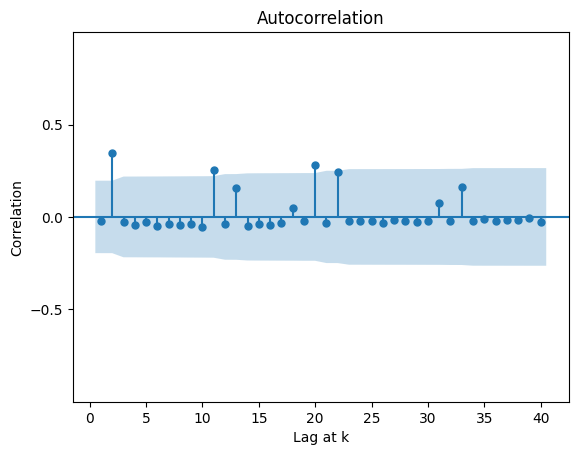

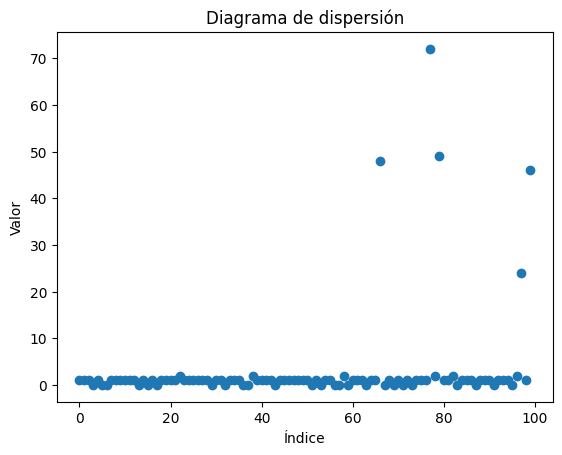

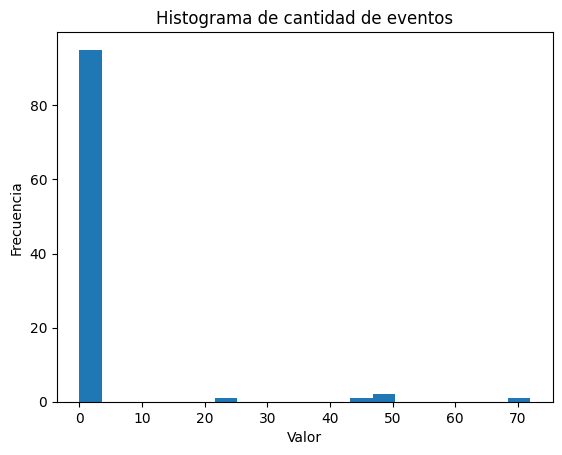


Media:
3.15

Desviación Estándar:
10.860339299348327

Mediana:
1.0

Mínimo:
0

Máximo:
72
---------------------
Resultados del ajuste
---------------------
Distribución:   t
Dominio:        [-inf, inf]
Parámetros:     {'df': 0.43249718471643805, 'loc': 1.0, 'scale': 2.4461283495503436e-18}
Log likelihood: 1779.886130954874
AIC:            -3553.772261909748
BIC:            -3545.9567513517836


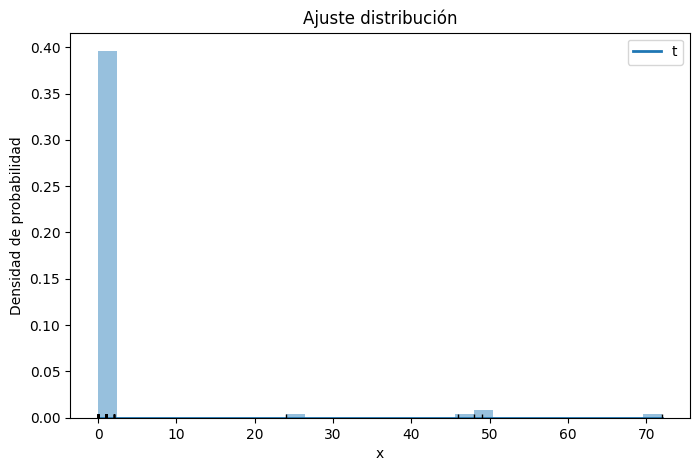

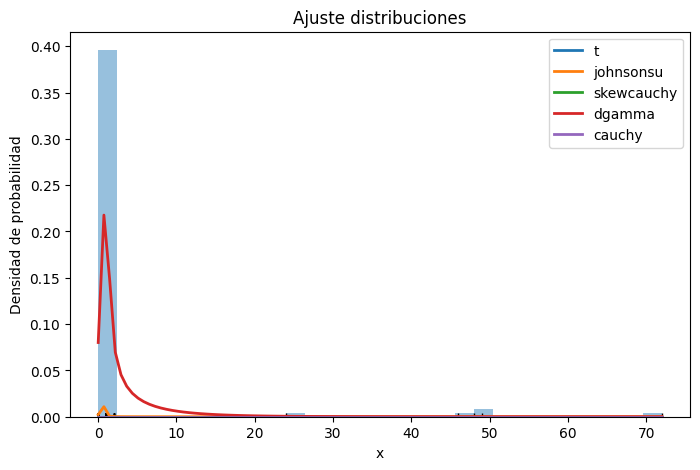

In [ ]:
print("Dataset D")
calcular_correlaciones(datos4)
generar_diagrama_dispersión(datos4)
generar_histograma(datos4)
calcular_estadisticos(datos4)
fig, ax = plt.subplots(figsize=(8,5))

plot_distribucion(
    x=datos4.to_numpy(),
    nombre_distribucion=resultados4['distribucion'][0],
    ax=ax
);
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos4.to_numpy(),
    nombre_distribuciones=resultados4['distribucion'][:5],
    ax=ax
);
